In [5]:
# autoreload
%load_ext autoreload
%autoreload 2

import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')

from mix_NCA.MixtureNCANoise import MixtureNCANoise
from mix_NCA.MixtureNCA import MixtureNCA
from mix_NCA.NCA import NCA
from mix_NCA.utils_simulations import grid_to_channels_batch, train_nca_dyn, plot_nca_prediction, classification_update_net, classification_update_net_unorm
from mix_NCA.utils_images import standard_update_net
from mix_NCA.TissueModel import create_complex_model_example, ComplexCellType
from mix_NCA.BiologicalMetrics import compare_generated_distributions
from mix_NCA.utils_formatting import create_latex_table_simulation, create_latex_table_emojis, create_latex_table_cifar, create_latex_table_emojis_rebuttal


In [7]:
stochastic_mix_nca = MixtureNCANoise(  classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = 5, temperature = 3, residual = False,  device = "cuda:2")
mix_nca = MixtureNCA(  classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = 5, residual = False, temperature = 3, device = "cuda:2")
nca = NCA( classification_update_net(6 * 3,  n_channels_out = 6), hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, residual = False, device = "cuda:2")
nca_with_noise = NCA( classification_update_net(6 * 3,  n_channels_out = 6 * 2), hidden_dim = 128, maintain_seed = False, use_alive_mask = False, 
                     state_dim = 6, residual = False, distribution = "normal",  device = "cuda:2")

# load the model
stochastic_mix_nca.load_state_dict(torch.load("../models/stochastic_mix_nca_biological_simulation.pth"))
mix_nca.load_state_dict(torch.load("../models/mix_nca_biological_simulation.pth"))
nca.load_state_dict(torch.load("../models/nca_biological_simulation.pth"))
nca_with_noise.load_state_dict(torch.load("../models/nca_model_with_noise.pt"))

nca_with_noise.random_updates = True

/tmp/ipykernel_2666985/3939052015.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stochastic_mix_nca.load_state_dict(torch.load("../models/stochastic_mix_nca_biological_

In [8]:
# load the histories
histories = np.load('histories.npy')


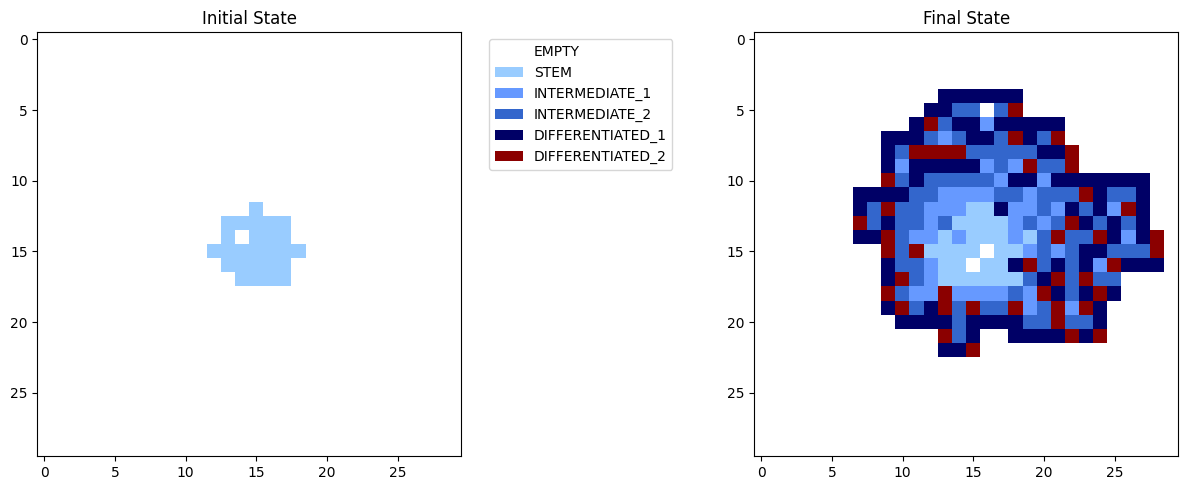

In [9]:
plot_nca_prediction(stochastic_mix_nca, initial_state=histories[10][0],cell_type_enum = ComplexCellType, n_cell_types= 6,steps=35,  show_intermediate = False, random = True, random_seed = 42, device = "cuda:2")

In [10]:
# Run comparison
results = compare_generated_distributions(histories, nca.to("cuda:2"), mix_nca.to("cuda:2"), stochastic_mix_nca.to("cuda:2"), nca_with_noise.to("cuda:2"), n_steps=35, device="cuda:2", n_evaluations=20)


/group/sottoriva/salvatore.milite/automata_project/nd_NCA/notebooks/../mix_NCA/BiologicalMetrics.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_mask = torch.tensor(self.true_dataset == ct.value, device=self.device)
/group/sottoriva/salvatore.milite/automata_project/nd_NCA/notebooks/../mix_NCA/BiologicalMetrics.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gen_mask = torch.tensor(self.generated_dataset == ct.value, device=self.device)
/group/sottoriva/salvatore.milite/automata_project/nd_NCA/notebooks/../mix_NCA/BiologicalMetrics.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().r

kl_divergence: 0.018348559737205505 ± 0.000686298600233318
chi_square: 0.017652882728725672 ± 0.0006461016351960632
categorical_mmd: 0.036227965354919435 ± 0.0016440484583705793
tumor_size: 0.060544814355671404 ± 0.007637413716325138
border_size: 0.1842711616860193 ± 0.00954976726541701
spatial_variance: 0.5566041751435924 ± 0.01976226766616227
kl_divergence: 0.027640935219824313 ± 0.0011390349148715567
chi_square: 0.025234858598560096 ± 0.0009783638651157521
categorical_mmd: 0.013556218147277832 ± 0.0011066964980846932
tumor_size: 0.10412189848721028 ± 0.012378373307616555
border_size: 0.054183846687274384 ± 0.012941010651041198
spatial_variance: 0.1078943188490987 ± 0.027298002661611864
kl_divergence: 0.11191720552742482 ± 0.0026772343666196267
chi_square: 0.08040896095335484 ± 0.0013324907255300557
categorical_mmd: 0.07084587812423707 ± 0.0006542629948793992
tumor_size: 0.47733679264783857 ± 0.0024740727912597638
border_size: 0.33901285455298924 ± 0.004580686922409567
spatial_varian

In [11]:
results


,Model Type,KL Divergence,KL Divergence SD,Chi-Square,Chi-Square SD,Categorical MMD,Categorical MMD SD,Tumor Size Diff,Tumor Size Diff SD,Border Size Diff,Border Size Diff SD,Spatial Variance Diff,Spatial Variance Diff SD
0,Standard NCA,2.057,±0.000,0.147,±0.000,0.099,±0.000,0.547,±0.000,0.430,±0.000,0.685,±0.000
1,Mixture NCA,0.018,±0.001,0.018,±0.001,0.036,±0.002,0.061,±0.008,0.184,±0.010,0.557,±0.020
2,Stochastic Mixture NCA,0.028,±0.001,0.025,±0.001,0.014,±0.001,0.104,±0.012,0.054,±0.013,0.108,±0.027
3,NCA with Noise,0.112,±0.003,0.080,±0.001,0.071,±0.001,0.477,±0.002,0.339,±0.005,0.572,±0.006


In [12]:
latex_table = create_latex_table_simulation(results)


In [13]:
print(latex_table)

\begin{table}[t]
\caption{Comparison of NCA variants}
\label{tab:nca-comparison}
\vskip 0.15in
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{lcccc}
\toprule
Model & KL-div & $\chi^2$ & Size & Border-W \\
\midrule
NCA & 2.057 ±0.000 & 0.147 ±0.000 & 0.547 ±0.000 & 0.430 ±0.000 \\
Mix-NCA & \textbf{0.018 ±0.001} & \textbf{0.018 ±0.001} & \textbf{0.061 ±0.008} & 0.184 ±0.010 \\
SMix-NCA & 0.028 ±0.001 & 0.025 ±0.001 & 0.104 ±0.012 & \textbf{0.054 ±0.013} \\
NCA with Noise & 0.112 ±0.003 & 0.080 ±0.001 & 0.477 ±0.002 & 0.339 ±0.005 \\
\bottomrule
\end{tabular}
\end{sc}
\end{small}
\end{center}
\vskip -0.1in
\end{table}



# Emoji experiment

In [49]:
# Load results from files
import pandas as pd
import glob
import os

# Get all CSV files from results directory
result_files = glob.glob("../results/experiment_1F*/detailed_metrics.csv")

# Initialize list to store all results
all_results = []

# Read and combine all result files
for file in result_files:
    df = pd.read_csv(file)
    df["emoji"] = (file.split("/")[-2]).split("_")[1]
    all_results.append(df)

# Combine all results into one dataframe
results = pd.concat(all_results, ignore_index=True)


In [57]:
# Group by emoji, model type, and perturbation type
summary = results.groupby(['emoji', 'Model Type', 'Perturbation Type'])['Final Error'].agg(['mean', 'std']).round(4)

# Unstack perturbation type to create columns
summary_table = summary.unstack()

# Create a formatter function for the values
def format_cell(mean, std):
    return f"{mean:.4f} ±{std:.4f}"

# Format the table
formatted_table = pd.DataFrame(
    index=summary_table.index,
    columns=summary_table.columns.levels[1],
    data=[[format_cell(summary_table[('mean', pt)][idx], summary_table[('std', pt)][idx]) 
           for pt in summary_table.columns.levels[1]]
          for idx in summary_table.index]
)




{}

In [73]:
# generate the latex table
latex_table = create_latex_table_emojis(results)

print(latex_table)

\begin{table}[t]
\caption{Performance Across Different Perturbations}
\label{tab:perturbation-results}
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{@{}lccccccc@{}}
\toprule
Model & Del 5x5px & Del 10x10px & Noise 10\% & Noise 25\% & Removal 100px & Removal 500px & Loss \\
\midrule
\multicolumn{8}{l}{\twemoji{whale}} \\
NCA & 0.024 ±0.008 & 0.027 ±0.009 & 0.049 ±0.007 & 0.052 ±0.010 & 0.026 ±0.006 & 0.032 ±0.011 & 0.010 \\
MNCA & \textbf{0.007 ±0.003} & \textbf{0.008 ±0.003} & 0.071 ±0.002 & 0.079 ±0.004 & \textbf{0.007 ±0.003} & \textbf{0.010 ±0.003} & 0.010 \\
MNCA w/ Noise & 0.008 ±0.002 & 0.010 ±0.003 & \textbf{0.009 ±0.004} & \textbf{0.013 ±0.006} & 0.009 ±0.002 & 0.011 ±0.003 & \textbf{0.009} \\
\midrule
\multicolumn{8}{l}{\twemoji{smile}} \\
NCA & 0.025 ±0.005 & 0.027 ±0.006 & 0.025 ±0.007 & 0.030 ±0.006 & 0.025 ±0.005 & 0.030 ±0.006 & \textbf{0.018} \\
MNCA & 0.016 ±0.008 & 0.026 ±0.009 & 0.013 ±0.006 & \textbf{0.018 ±0.005} & 0.014 ±0.005 & \textbf{0.021 ±0.005} & 0.

In [3]:
n_rules_list = [1,2,3,4,5,6,7,8]
histories = np.load('histories.npy')


# load all rules models
mixture_models = [MixtureNCA(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = n_rules, residual = False) for n_rules in n_rules_list] 
mixture_stochastic_models = [MixtureNCANoise(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = n_rules, residual = False) for n_rules in n_rules_list]

for i in range(len(n_rules_list)):
    mixture_models[i].load_state_dict(torch.load(f"../models/mixture_model_n_rules_{n_rules_list[i]}.pth"))
    mixture_stochastic_models[i].load_state_dict(torch.load(f"../models/mixture_stochastic_model_n_rules_{n_rules_list[i]}.pth"))

/tmp/ipykernel_917885/3022397191.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mixture_models[i].load_state_dict(torch.load(f"../models/mixture_model_n_rules_{n_rules_

In [6]:
# untrained NCA model that just returns the input data as it is
untrained_nca = NCA(classification_update_net(6 * 3, n_channels_out = 6), hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, residual = False)


In [12]:
i = 2
results = compare_generated_distributions(histories, untrained_nca, mixture_models[i], mixture_stochastic_models[i], n_steps=35, device="cuda", n_evaluations=1)


True dataset shape after stacking: torch.Size([200, 30, 30])

Processing Standard NCA
Dataset shapes - True: torch.Size([200, 30, 30]), Generated: torch.Size([200, 30, 30])

Distribution metrics:
True distribution: tensor([0.0000, 0.1324, 0.1718, 0.2390, 0.3248, 0.1320], device='cuda:0')
Generated distribution: tensor([0.0000, 0.0000, 0.0333, 0.0000, 0.0322, 0.9344], device='cuda:0')
KL divergence: 7.0058
Chi-square distance: 1.3085
Categorical MMD: 1.5586

Tumor size distributions:
True - Mean: 294.14, Std: 79.69
Generated - Mean: 900.00, Std: 0.00
Wasserstein distance: 2.0597

Processing Mixture NCA
Dataset shapes - True: torch.Size([200, 30, 30]), Generated: torch.Size([200, 30, 30])

Distribution metrics:
True distribution: tensor([0.0000, 0.1324, 0.1718, 0.2390, 0.3248, 0.1320], device='cuda:0')
Generated distribution: tensor([0.0000, 0.1218, 0.2112, 0.2231, 0.3256, 0.1184], device='cuda:0')
KL divergence: 0.0057
Chi-square distance: 0.0058
Categorical MMD: 0.0989

Tumor size dist

In [14]:
results

,Model Type,KL Divergence,KL Divergence SD,Chi-Square,Chi-Square SD,Categorical MMD,Categorical MMD SD,Tumor Size Diff,Tumor Size Diff SD,Border Size Diff,Border Size Diff SD,Spatial Variance Diff,Spatial Variance Diff SD
0,Standard NCA,7.006,±0.000,1.309,±0.000,1.559,±0.000,2.060,±0.000,0.410,±0.000,1.002,±0.000
1,Mixture NCA,0.006,±0.000,0.006,±0.000,0.099,±0.000,0.319,±0.000,0.265,±0.000,0.472,±0.000
2,Stochastic Mixture NCA,0.075,±0.000,0.065,±0.000,0.087,±0.000,0.248,±0.000,0.100,±0.000,0.194,±0.000


In [16]:
# run comparison with models of different number of rules
all_results = []

for i in range(len(n_rules_list)):
    results = compare_generated_distributions(histories, untrained_nca, mixture_models[i], mixture_stochastic_models[i], n_steps=35, device="cuda", n_evaluations=1)
    results["n_rules"] = n_rules_list[i]
    all_results.append(results)

# bind rows 
all_results = pd.concat(all_results, ignore_index=True)

all_results

/home/salvatore.milite/data/automata_project/nd_NCA/mix_NCA/BiologicalMetrics.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_mask = torch.tensor(self.true_dataset == ct.value, device=self.device)
/home/salvatore.milite/data/automata_project/nd_NCA/mix_NCA/BiologicalMetrics.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gen_mask = torch.tensor(self.generated_dataset == ct.value, device=self.device)
/home/salvatore.milite/data/automata_project/nd_NCA/mix_NCA/BiologicalMetrics.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

,Model Type,KL Divergence,KL Divergence SD,Chi-Square,Chi-Square SD,Categorical MMD,Categorical MMD SD,Tumor Size Diff,Tumor Size Diff SD,Border Size Diff,Border Size Diff SD,Spatial Variance Diff,Spatial Variance Diff SD,n_rules
0,Standard NCA,7.006,±0.000,1.309,±0.000,1.559,±0.000,2.060,±0.000,0.410,±0.000,1.002,±0.000,1
1,Mixture NCA,0.773,±0.000,0.146,±0.000,0.112,±0.000,0.560,±0.000,0.417,±0.000,0.685,±0.000,1
2,Stochastic Mixture NCA,0.718,±0.000,0.145,±0.000,0.113,±0.000,0.564,±0.000,0.417,±0.000,0.685,±0.000,1
3,Standard NCA,7.006,±0.000,1.309,±0.000,1.559,±0.000,2.060,±0.000,0.410,±0.000,1.002,±0.000,2
4,Mixture NCA,0.040,±0.000,0.037,±0.000,0.075,±0.000,0.315,±0.000,0.187,±0.000,0.359,±0.000,2
5,Stochastic Mixture NCA,0.105,±0.000,0.081,±0.000,0.110,±0.000,0.515,±0.000,0.381,±0.000,0.643,±0.000,2
6,Standard NCA,7.006,±0.000,1.309,±0.000,1.559,±0.000,2.060,±0.000,0.410,±0.000,1.002,±0.000,3
7,Mixture NCA,0.006,±0.000,0.006,±0.000,0.099,±0.000,0.319,±0.000,0.265,±0.000,0.472,±0.000,3
8,Stochastic Mixture NCA,0.075,±0.000,0.065,±0.000,0.087,±0.000,0.248,±0.000,0.100,±0.000,0.194,±0.000,3
9,Standard NCA,7.006,±0.000,1.309,±0.000,1.559,±0.000,2.060,±0.000,0.410,±0.000,1.002,±0.000,4


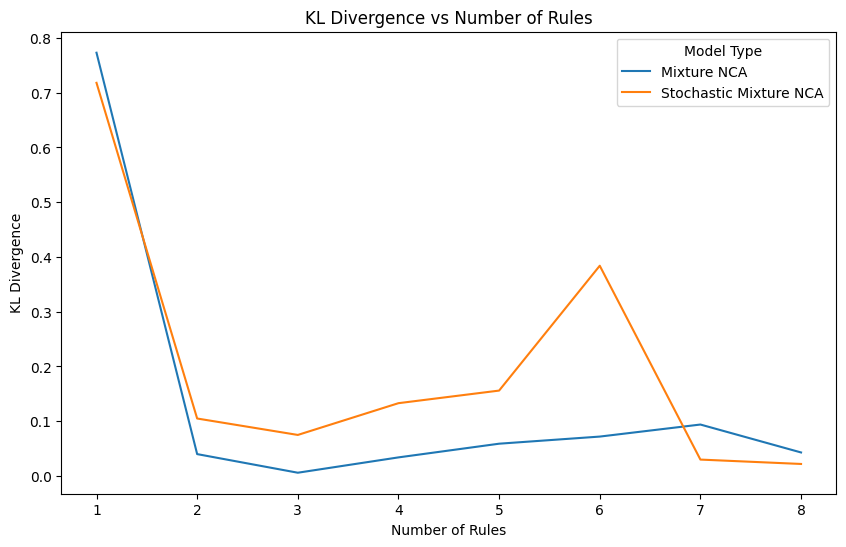

In [31]:
# remove Standard NCA from the dataframe
all_results = all_results[all_results["Model Type"] != "Standard NCA"]

# convert KL Divergence to float
all_results["KL Divergence"] = all_results["KL Divergence"].astype(float)
all_results["Tumor Size Diff"] = all_results["Tumor Size Diff"].astype(float)
all_results["Border Size Diff"] = all_results["Border Size Diff"].astype(float)

# plot n_rules vs final error
plt.figure(figsize=(10, 6))
sns.lineplot(x="n_rules", y="KL Divergence", data=all_results, hue="Model Type")
plt.xlabel("Number of Rules")
plt.ylabel("KL Divergence")
plt.title("KL Divergence vs Number of Rules")
plt.show()

# CIFAR experiment

In [8]:
# Load results from files
import pandas as pd
import glob
import os

# Get all CSV files from results directory
result_files = glob.glob("../results/experiment*_0_robustness/detailed_metrics.csv")
result_files2 = glob.glob("../results_new_experiment/experiment*_0_robustness/detailed_metrics.csv")
# Initialize list to store all results
all_results = []

# Read and combine all result files
for file in result_files:
    df = pd.read_csv(file)
    df["Category"] = (file.split("/")[-2]).split("_")[1]
    all_results.append(df)

# Combine all results into one dataframe
results = pd.concat(all_results, ignore_index=True)


In [9]:
result_files2

[]

In [2]:
# Group by emoji, model type, and perturbation type
summary = results.groupby(['Category', 'Model Type', 'Perturbation Type'])['Final Error'].agg(['mean', 'std']).round(4)

# Unstack perturbation type to create columns
summary_table = summary.unstack()

# Create a formatter function for the values
def format_cell(mean, std):
    return f"{mean:.4f} ±{std:.4f}"

# Format the table
formatted_table = pd.DataFrame(
    index=summary_table.index,
    columns=summary_table.columns.levels[1],
    data=[[format_cell(summary_table[('mean', pt)][idx], summary_table[('std', pt)][idx]) 
           for pt in summary_table.columns.levels[1]]
          for idx in summary_table.index]
)

In [3]:
print(formatted_table.head())

Perturbation Type     100 Masked Pixels 500 Masked Pixels     Deletion 10  \
Category   Model Type                                                       
airplane   Mixture       0.0012 ±0.0012    0.0085 ±0.0045  0.0033 ±0.0032   
           Standard      0.0213 ±0.0083    0.0226 ±0.0117  0.0213 ±0.0095   
           Stochastic    0.0014 ±0.0020    0.0087 ±0.0024  0.0040 ±0.0041   
automobile Mixture       0.0027 ±0.0016    0.0058 ±0.0022  0.0037 ±0.0021   
           Standard      0.0095 ±0.0045    0.0155 ±0.0053  0.0091 ±0.0045   

Perturbation Type          Deletion 5       Noise 0.1       Noise 0.25  
Category   Model Type                                                   
airplane   Mixture     0.0010 ±0.0008  0.0132 ±0.0024  6.5645 ±22.8378  
           Standard    0.0198 ±0.0087  0.0149 ±0.0098   0.0222 ±0.0106  
           Stochastic  0.0010 ±0.0011  0.0081 ±0.0044   0.0110 ±0.0047  
automobile Mixture     0.0024 ±0.0015  0.0092 ±0.0022   0.0178 ±0.0022  
           Standard   

In [6]:
print(create_latex_table_cifar(formatted_table))

\begin{table}[t]
\caption{Performance Across Different Perturbations}
\label{tab:perturbation-results}
\begin{center}
\begin{small}
\begin{tabular}{lcccccc}
\toprule
Model & Del 5x5px & Del 10x10px & Noise 10\% & Noise 25\% & Rem 100px & Rem 500px \\
\midrule
\multicolumn{7}{l}{airplane} \\
NCA & 0.0213 ±0.0083 & 0.0226 ±0.0117 & 0.0213 ±0.0095 & 0.0198 ±0.0087 & 0.0149 ±0.0098 & 0.0222 ±0.0106 \\
MNCA & \textbf{0.0012 ±0.0012} & \textbf{0.0085 ±0.0045} & \textbf{0.0033 ±0.0032} & \textbf{0.0010 ±0.0008} & 0.0132 ±0.0024 & 6.5645 ±22.8378 \\
MNCA w/ N & 0.0014 ±0.0020 & 0.0087 ±0.0024 & 0.0040 ±0.0041 & \textbf{0.0010 ±0.0011} & \textbf{0.0081 ±0.0044} & \textbf{0.0110 ±0.0047} \\
\midrule
\multicolumn{7}{l}{automobile} \\
NCA & 0.0095 ±0.0045 & 0.0155 ±0.0053 & 0.0091 ±0.0045 & 0.0083 ±0.0036 & 0.0139 ±0.0054 & 0.0210 ±0.0055 \\
MNCA & \textbf{0.0027 ±0.0016} & 0.0058 ±0.0022 & 0.0037 ±0.0021 & \textbf{0.0024 ±0.0015} & 0.0092 ±0.0022 & 0.0178 ±0.0022 \\
MNCA w/ N & 0.0038 ±0.0024 & \

# Emoji Experimnt Rebuttal


In [94]:
# Load results from files
import pandas as pd
import glob
import os

# Get all CSV files from results directory
result_files = glob.glob("../results_new_experiment/experiment_1F*/detailed_metrics.csv")

# Initialize list to store all results
all_results = []

# Read and combine all result files
for file in result_files:
    df = pd.read_csv(file)
    df["emoji"] = (file.split("/")[-2]).split("_")[1]
    all_results.append(df)

# Combine all results into one dataframe
results = pd.concat(all_results, ignore_index=True)


In [95]:
# substitute standard with SNCA
results["Model Type"] = results["Model Type"].replace("Standard", "GCA")
# select only the rows where Model Type is GCA
new_results = results[results["Model Type"] == "GCA"]


In [96]:
# Load results from files
import pandas as pd
import glob
import os

# Get all CSV files from results directory
result_files = glob.glob("../results/experiment_1F*/detailed_metrics.csv")

# Initialize list to store all results
all_results = []

# Read and combine all result files
for file in result_files:
    df = pd.read_csv(file)
    df["emoji"] = (file.split("/")[-2]).split("_")[1]
    all_results.append(df)

# Combine all results into one dataframe
results = pd.concat(all_results, ignore_index=True)

In [97]:
# concatenate the two dataframes
results = pd.concat([new_results, results], ignore_index=True)


In [98]:
# Group by emoji, model type, and perturbation type
summary = results.groupby(['emoji', 'Model Type', 'Perturbation Type'])['Final Error'].agg(['mean', 'std']).round(4)

# Unstack perturbation type to create columns
summary_table = summary.unstack()

# Create a formatter function for the values
def format_cell(mean, std):
    return f"{mean:.4f} ±{std:.4f}"

# Format the table
formatted_table = pd.DataFrame(
    index=summary_table.index,
    columns=summary_table.columns.levels[1],
    data=[[format_cell(summary_table[('mean', pt)][idx], summary_table[('std', pt)][idx]) 
           for pt in summary_table.columns.levels[1]]
          for idx in summary_table.index]
)



In [100]:
formatted_table

Perturbation Type 100 Masked Pixels 500 Masked Pixels     Deletion 10  \
emoji Model Type                                                        
1F433 GCA            0.0156 ±0.0029    0.0223 ±0.0038  0.0166 ±0.0038   
      Mixture        0.0074 ±0.0034    0.0099 ±0.0033  0.0079 ±0.0025   
      Standard       0.0259 ±0.0064    0.0318 ±0.0108  0.0272 ±0.0093   
      Stochastic     0.0085 ±0.0024    0.0110 ±0.0030  0.0097 ±0.0028   
1F604 GCA            0.0272 ±0.0055    0.0322 ±0.0083  0.0316 ±0.0081   
      Mixture        0.0142 ±0.0055    0.0208 ±0.0049  0.0263 ±0.0087   
      Standard       0.0254 ±0.0053    0.0304 ±0.0058  0.0269 ±0.0062   
      Stochastic     0.0083 ±0.0028    0.0242 ±0.0055  0.0161 ±0.0065   
1F620 GCA            0.0208 ±0.0056    0.0250 ±0.0076  0.0245 ±0.0069   
      Mixture        0.0099 ±0.0023    0.0148 ±0.0028  0.0167 ±0.0054   
      Standard       0.0191 ±0.0058    0.0251 ±0.0067  0.0215 ±0.0062   
      Stochastic     0.0090 ±0.0025    0.0129 ±0.0034  0.0149 ±0.0045   
1F914 GCA            0.0151 ±0.0034    0.0293 ±0.0071  0.0185 ±0.0073   
      Mixture        0.0084 ±0.0025    0.0186 ±0.0066  0.0208 ±0.0083   
      Standard       0.0140 ±0.0035    0.0222 ±0.0038  0.0179 ±0.0050   
      Stochastic     0.0068 ±0.0023    0.0175 ±0.0033  0.0151 ±0.0063   
1F951 GCA            0.0131 ±0.0046    0.0320 ±0.0088  0.0204 ±0.0103   
      Mixture        0.0026 ±0.0006    0.0058 ±0.0014  0.0057 ±0.0036   
      Standard       0.0323 ±0.0185    0.0972 ±0.0275  0.0563 ±0.0256   
      Stochastic     0.0061 ±0.0017    0.0099 ±0.0025  0.0111 ±0.0044   
1F984 GCA            0.0248 ±0.0064    0.0298 ±0.0079  0.0401 ±0.0149   
      Mixture        0.0087 ±0.0018    0.0116 ±0.0026  0.0131 ±0.0051   
      Standard       0.0226 ±0.0063    0.0322 ±0.0095  0.0298 ±0.0160   
      Stochastic     0.0229 ±0.0104    0.0305 ±0.0120  0.0294 ±0.0121   

Perturbation Type      Deletion 5       Noise 0.1      Noise 0.25  
emoji Model Type                                                   
1F433 GCA          0.0149 ±0.0028  0.0302 ±0.0038  0.0365 ±0.0049  
      Mixture      0.0071 ±0.0030  0.0711 ±0.0016  0.0790 ±0.0043  
      Standard     0.0244 ±0.0079  0.0494 ±0.0073  0.0521 ±0.0099  
      Stochastic   0.0083 ±0.0022  0.0089 ±0.0037  0.0134 ±0.0061  
1F604 GCA          0.0273 ±0.0062  0.0386 ±0.0077  0.0389 ±0.0085  
      Mixture      0.0156 ±0.0077  0.0133 ±0.0063  0.0179 ±0.0048  
      Standard     0.0246 ±0.0053  0.0249 ±0.0066  0.0305 ±0.0060  
      Stochastic   0.0072 ±0.0026  0.0076 ±0.0019  0.0264 ±0.0053  
1F620 GCA          0.0200 ±0.0067  0.0279 ±0.0062  0.0360 ±0.0082  
      Mixture      0.0090 ±0.0021  0.0107 ±0.0022  0.0117 ±0.0025  
      Standard     0.0182 ±0.0039  0.0220 ±0.0060  0.0259 ±0.0067  
      Stochastic   0.0088 ±0.0033  0.0076 ±0.0021  0.0157 ±0.0033  
1F914 GCA          0.0146 ±0.0037  0.0244 ±0.0061  0.0324 ±0.0078  
      Mixture      0.0091 ±0.0040  0.0086 ±0.0034  0.0130 ±0.0048  
      Standard     0.0141 ±0.0030  0.0142 ±0.0034  0.0174 ±0.0037  
      Stochastic   0.0063 ±0.0020  0.0047 ±0.0013  0.0085 ±0.0022  
1F951 GCA          0.0127 ±0.0043  0.0221 ±0.0061  0.0335 ±0.0084  
      Mixture      0.0022 ±0.0005  0.0026 ±0.0005  0.0082 ±0.0046  
      Standard     0.0353 ±0.0184  0.0731 ±0.0126  0.1014 ±0.0210  
      Stochastic   0.0060 ±0.0019  0.0055 ±0.0017  0.0094 ±0.0021  
1F984 GCA          0.0247 ±0.0086  0.0598 ±0.0115  0.0553 ±0.0123  
      Mixture      0.0086 ±0.0023  0.0095 ±0.0020  0.0119 ±0.0020  
      Standard     0.0212 ±0.0079  0.0802 ±0.0099  0.0785 ±0.0282  
      Stochastic   0.0219 ±0.0079  0.0245 ±0.0094  0.0389 ±0.0121

In [77]:
# generate the latex table
latex_table = create_latex_table_emojis_rebuttal(results)

print(latex_table)

\begin{table}[t]
\caption{Performance Across Different Perturbations}
\label{tab:perturbation-results}
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{@{}lcccccc@{}}
\toprule
Model & Del 5x5px & Del 10x10px & Noise 10\% & Noise 25\% & Removal 100px & Removal 500px \\
\midrule
\multicolumn{7}{l}{\twemoji{whale}} \\
NCA & 0.024 ±0.008 & 0.027 ±0.009 & 0.049 ±0.007 & 0.052 ±0.010 & 0.026 ±0.006 & 0.032 ±0.011 \\
GCA & 0.018 ±0.005 & 0.021 ±0.006 & 0.036 ±0.005 & 0.049 ±0.008 & 0.020 ±0.004 & 0.026 ±0.007 \\
MNCA & \textbf{0.007 ±0.003} & \textbf{0.008 ±0.003} & 0.071 ±0.002 & 0.079 ±0.004 & \textbf{0.007 ±0.003} & \textbf{0.010 ±0.003} \\
MNCA w/ Noise & 0.008 ±0.002 & 0.010 ±0.003 & \textbf{0.009 ±0.004} & \textbf{0.013 ±0.006} & 0.009 ±0.002 & 0.011 ±0.003 \\
\midrule
\multicolumn{7}{l}{\twemoji{smile}} \\
NCA & 0.025 ±0.005 & 0.027 ±0.006 & 0.025 ±0.007 & 0.030 ±0.006 & 0.025 ±0.005 & 0.030 ±0.006 \\
GCA & 0.020 ±0.006 & 0.024 ±0.008 & 0.020 ±0.006 & 0.027 ±0.006 & 0.021 ±0.005